# Complex Networks - Practical Exercise
###  Analysis of football match results over history

### Author: Gregorio Mendoza Serrano
---
# Part 1

Create a complex network where the nodes are national teams and the edges are the matches they have played against each other. Consider a directed network, i.e., distinguishing between the visiting team and the home team. This network is also a multigraph.

Download the dataset file from the external link or import from your local location:

In [1]:
# ... location of the file

Import the necessary libraries:

In [ ]:
import pandas as pd
import networkx as nx
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Import the dataset and create the Multigraph:

In [ ]:
# Cargamos el dataset
df = pd.read_csv('./results.csv')

# Creamos un grafo dirigido
G = nx.MultiDiGraph()

# Añadimos los nodos y las aristas
for index, row in df.iterrows():
    G.add_node(row['home_team'])
    G.add_node(row['away_team'])
    G.add_edge(row['home_team'], row['away_team'])

# Ahora G es una red compleja donde los nodos son las selecciones nacionales
# y las aristas representan los partidos jugados entre ellos.



---



# Part 2

Let's the network you have created by studying the parameters presented in class (centrality, degree, clustering, assortativity):

**Calculation of the radius and diameter of the network:** First, we will perform a check to see if the network is connected or not (i.e., to see if there are isolated nodes or groups), and after that, if it is not connected, we will calculate the radii and diameters of its components, from which we will choose the maximum diameter and the minimum radius - these are the global metrics of the network that we are looking for.

For this purpose, we use an auxiliary undirected network called `G_aux` in the code. This network will only be used in the code block below.

In [ ]:
# Creamos un grafo no dirigido auxiliar desde nuestro DataFrame:
G_aux = nx.from_pandas_edgelist(df, "home_team", "away_team", create_using=nx.Graph())

# Comprobamos si el grafo está conectado
is_connected = nx.is_connected(G_aux)

if not is_connected:
    # Calculamos métricas para los componentes por separado:
    components = list(nx.connected_components(G_aux))

    diameters = []
    radii = []

    for component in components:
      # Calculamos métricas para los subgrafos por separado:
        subgraph = G_aux.subgraph(component)
        diameters.append(nx.diameter(subgraph))
        radii.append(nx.radius(subgraph))

    # Calculamos métricas para el grafo completo:
    diameter = max(diameters)
    radius = min(radii)

    print("Diametro del grafo completo (máximo entre subgrafos):", diameter)
    print("Radio del grafo completo: (mímino entre subgrafos):", radius)

else:
    # Calculamos métricas para el grafo completo:
    diameter = nx.diameter(G_aux)
    radius = nx.radius(G_aux)

    print("Diameter of the entire graph:", diameter)
    print("Radius of the entire graph:", radius)


Diametro del grafo completo (máximo entre subgrafos): 7
Radio del grafo completo: (mímino entre subgrafos): 1


According to the definitions of the radius and diameter metrics, we conclude that:
- The radius of the entire graph is 1, so there are many isolated groups that are not connected.
- The diameter of the entire graph is 7: If we ignore the existence of isolated groups mentioned earlier, we would find a large subnetwork with characteristics that could somewhat resemble a *small-world*.

Let's print the degree of all football teams in a tabular format **with descending degree**, through a Pandas DataFrame:

In [ ]:
# Calculamos el grado de cada selección:
grado = G.degree()

# Creamos un dataframe de pandas para mejor visualización:
df_grado = pd.DataFrame(list(grado), columns=['Nodo', 'Grado'])

# Ordenamos grados de mayor a menor:
df_grado_ordenado = df_grado.sort_values(by='Grado', ascending=False)

df_grado_ordenado

,Nodo,Grado
19,Sweden,1071
1,England,1059
7,Argentina,1037
28,Brazil,1032
18,Germany,999
...,...,...
287,Cilento,1
295,Saugeais,1
312,Ryūkyū,1
301,Seborga,1


Draw a histogram of the degrees of the nodes in the network to better understand its morphology and clustering:

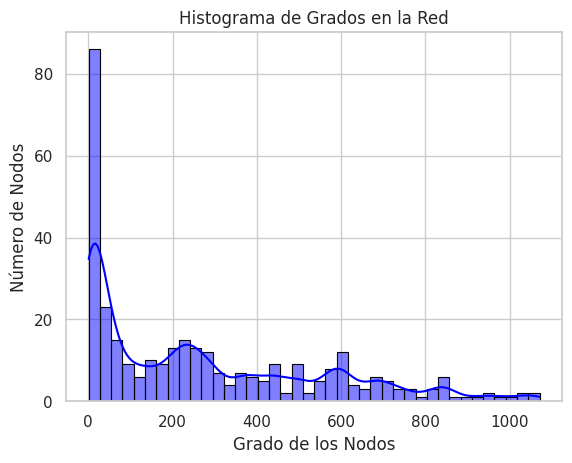

In [ ]:
# Creamos un diccionario con el grado de cada nodo en el multigrafo dirigido
degrees = dict(grado)

# Configurar Seaborn
sns.set(style="whitegrid")

# Crear un histograma con Seaborn
sns.histplot(list(degrees.values()), bins=40,
             kde=True, color='blue', edgecolor='black', kde_kws={'bw_method': 0.1})

# Configurar el gráfico
plt.title('Histograma de Grados en la Red')
plt.xlabel('Grado de los Nodos')
plt.ylabel('Número de Nodos')
plt.xticks()

# Mostrar el histograma
plt.show()

In the histogram, we can observe that the network is poorly connected given the abundance of nodes with very low degrees.

The distribution we obtain seems to be a mix between power-law (as described above) and several humps that could represent several modes within the distribution (around degree 200-225 and around degree 600). It is most likely that around these two modes, European and American selections are centered, which, due to their continuous participation in global tournaments, are more connected in the graph.

At the end of the histogram tail, beyond degree 800, we would find the oldest selections with a broader trajectory (England, Sweden, Argentina, etc.).

Proof of the above can be observed in the DataFrame that lists the degrees of each node.

Calculate and plot the probability density function (PDF) and the cumulative density distribution function (CDF) of the previous histogram.

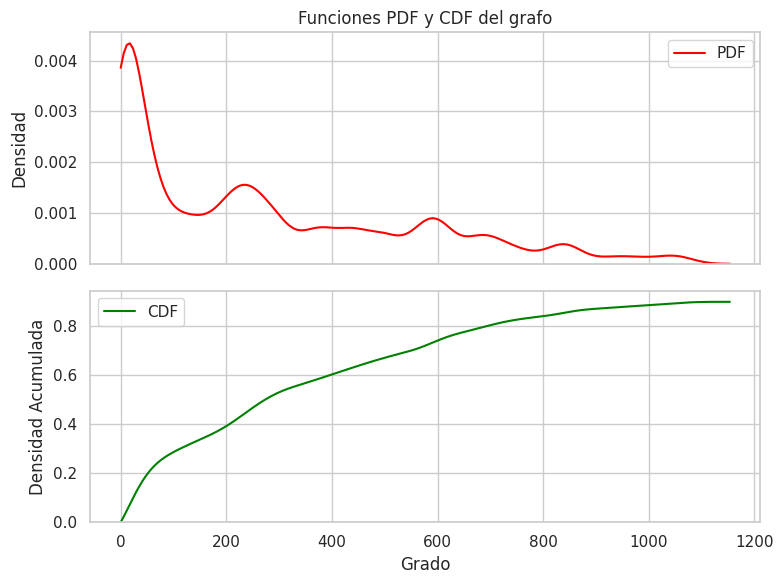

In [ ]:
# Crear subgráficos
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Graficar la PDF suavizada en el primer subgráfico
sns.kdeplot(list(degrees.values()), color='red', label='PDF',
            bw_method=0.1, clip=(0, 1400), ax=ax1)
ax1.set_ylabel('Densidad')
ax1.legend()
ax1.set_title('Funciones PDF y CDF del grafo')

# Graficar la CDF suavizada en el segundo subgráfico
sns.kdeplot(list(degrees.values()), cumulative=True,
            bw_method=0.1, clip=(0, 1400),
            color='green', label='CDF', ax=ax2)
ax2.set_xlabel('Grado')
ax2.set_ylabel('Densidad Acumulada')
ax2.legend()

# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()

In line with what was explained in the histogram, we observe that the PDF starts at a very high point, which makes the CDF have the most pronounced jump at the beginning of the X-axis.

After that, the evolution of the PDF is slow and low, which implies that the cumulative evolution of the CDF is slow and increasingly flat.

We perform the same process for the calculation and representation of centrality:

In [ ]:
# Calculamos la centralidad de cada nodo/selección:
centralidad = nx.degree_centrality(G)

# Creamos un dataframe de pandas para mejor visualización:
df_centralidad = pd.DataFrame(list(centralidad.items()), columns=['Nodo', 'Centralidad'])

# Visualizamos el dataframe:
df_centralidad

,Nodo,Centralidad
0,Scotland,2.489426
1,England,3.199396
2,Wales,2.120846
3,Northern Ireland,2.063444
4,United States,2.265861
...,...,...
327,Aymara,0.006042
328,Elba Island,0.003021
329,West Papua,0.003021
330,Ticino,0.006042


Next, we calculate the degree of Assortativity of the network:

In [ ]:
# Asortatividad
asortatividad = nx.degree_assortativity_coefficient(G)
print("Asortatividad: ", asortatividad.round(3))
print("\n")

Asortatividad:  0.431




To calculate the average clustering of the network, we need to calculate the clustering of each node (team) manually and sum them using a loop.

Next, the following magnitudes of characterization are calculated and visualized:

In [ ]:
# Calcular el coeficiente de clustering por nodo
clustering_coefficients = {}

for node in G.nodes:
    # Obtener vecinos y vecinos entrantes
    neighbors = set(G.neighbors(node))
    in_neighbors = set(G.predecessors(node))

    # Calcular el coeficiente de clustering si el nodo tiene más de un vecino
    if len(neighbors) > 1:
        clustering_coefficient = len(set(neighbors).intersection(in_neighbors)) / (len(neighbors) * (len(neighbors) - 1))
        clustering_coefficients[node] = clustering_coefficient
    else:
        clustering_coefficients[node] = 0.0  # Si el nodo tiene menos de dos vecinos, establecer el coeficiente en 0

# Calcular el promedio de los coeficientes de clustering
average_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)

# Imprimir el coeficiente de clustering promedio
print("Coeficiente de Clustering Promedio:", round(average_clustering_coefficient, 4))

# Crear un DataFrame con los nodos y sus coeficientes de clustering
df_clustering = pd.DataFrame(list(clustering_coefficients.items()), columns=['Nodo', 'Coeficiente de Clustering'])

# Imprimir el DataFrame
print("\n")
df_clustering

Coeficiente de Clustering Promedio: 0.04




,Nodo,Coeficiente de Clustering
0,Scotland,0.013214
1,England,0.010957
2,Wales,0.012361
3,Northern Ireland,0.014014
4,United States,0.007789
...,...,...
327,Aymara,0.000000
328,Elba Island,0.000000
329,West Papua,0.000000
330,Ticino,0.000000


* Degree: The degree of a node in a graph is the number of connections it has. In this case, it represents the number of matches a national team has played.
* Centrality: The centrality of a node measures its relative importance within the graph. There are several ways to calculate it, but a common one is degree centrality, which is simply the degree of the node.
* Clustering (Clustering Coefficient): This metric measures the tendency of nodes to cluster. In this case, a high clustering coefficient for a national team could indicate that it tends to play matches against the same teams.
* Assortativity: This metric measures the similarity of connections in the graph. In this case, a high assortativity coefficient could indicate that national teams tend to play more matches against those that play a similar number of matches.

# Part 3

Visualize the network you have created, or part of it, using networkx and matplotlib. The visualizations can contain a subset of nodes and edges to facilitate understanding. The nodes should be labeled. Describe the steps you have followed.

To make visualization possible with networkx and Matplotlib, we will choose a specific node to create a subgraph of nodes connected to it and display it.

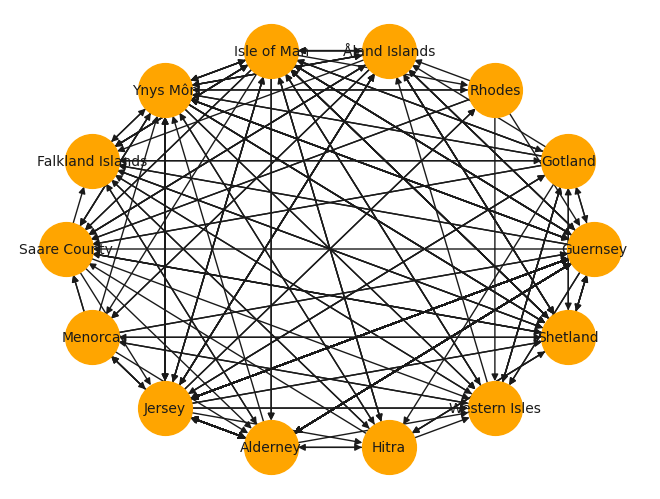

In [ ]:
import matplotlib.pyplot as plt

# Selecciona un nodo específico
nodo = 'Isle of Man'

# Crea una subred con los vecinos del nodo
vecinos = G.neighbors(nodo)
G_sub = G.subgraph([nodo] + list(vecinos))

# Generar la disposición de los nodos
pos = nx.circular_layout(G_sub)

# Dibujar la subred
nx.draw(G_sub, pos, with_labels=True, font_size=10,
        arrowsize=10, node_size=1500, node_color='orange')


# Mostrar el gráfico
plt.show()


`'Isle of Man'` was chosen because it is a node with a not-too-high degree (see the DataFrame that lists the degrees in section 2).

It is striking that in the subgraph of the image, we observe a cluster of nodes with isolated behavior similar to that of a highly connected random network ("all with all").

The teams in the subgraph have in common that they belong to islands (or island-nations in some cases). Since they are not very connected with the rest of the network, we conclude that they may be playing some tournament among themselves, and this is confirmed by an internet search:
https://en.wikipedia.org/wiki/Football_at_the_Island_Games

The "Football at the Islands" tournament is a periodic competition in which, among others, the top selections compete.